In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Wrangling

In [2]:
ultimate = pd.read_json('ultimate_data_challenge.json')
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [3]:
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


Now that the database is loaded, I need to check the data to see what, if any, cleaning needs to be done.  I'll be looking for misspellings, mismatched data entry, and major outliers that may indicate data errors.

In [4]:
ultimate['ultimate_black_user'].unique()

array([ True, False])

In [5]:
#changing to 1s and 0s for later modelling...
ultimate['ultimate_black_user'] = ultimate['ultimate_black_user'].astype(int)

In [6]:
ultimate.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [7]:
ultimate.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [8]:
print(ultimate.avg_rating_of_driver.max())
print(ultimate.avg_rating_of_driver.min())

5.0
1.0


In [9]:
print(ultimate.trips_in_first_30_days.max())
print(ultimate.trips_in_first_30_days.min())

125
0


In [10]:
print(ultimate.last_trip_date.max())
print(ultimate.last_trip_date.min())

2014-07-01
2014-01-01


Everything looks pretty good at first glance.  I know we have some NaN values, but i will keep them for now, and determine the best way to deal with them in pre-processing.

# Data Exploration

What I'm going to do no next is create a new column in the dataframe indicating whether each rider is an active user or not.  I'll do this by determing which riders have taken trips in the last 30 days.

In [11]:
ultimate['active_user'] =  ultimate['last_trip_date'].apply(lambda x:1 if x > '2014-06-01' else 0)

In [12]:
ultimate['active_user'].value_counts(normalize=True)

0    0.6338
1    0.3662
Name: active_user, dtype: float64

### 36.6 % of the riders that signed up in January are still active users.

In [13]:
ultimate.head()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0


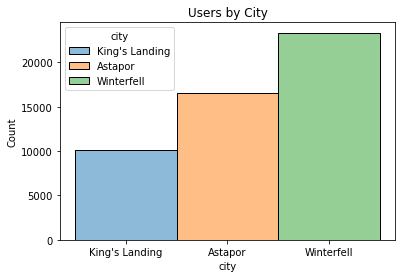

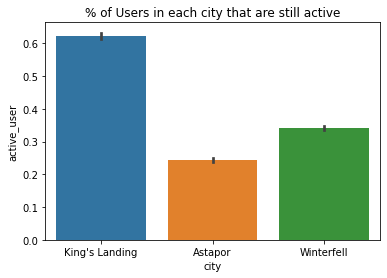

In [14]:
sns.histplot(data = ultimate, x = 'city', hue = 'city')
plt.title('Users by City')
plt.show()

sns.barplot(data = ultimate, x = 'city', y = 'active_user')
plt.title('% of Users in each city that are still active')
plt.show()

Although King's Landing accounted for only about 20% of our initial sign-ups, the retention rate was much better there than in the other 2 cities.

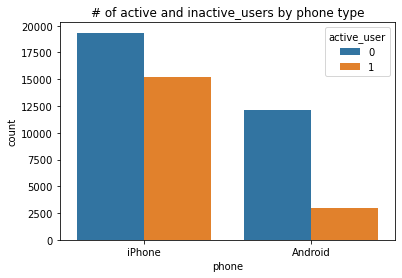

iPhone     0.697162
Android    0.302838
Name: phone, dtype: float64

In [15]:
sns.countplot(data = ultimate, x='phone', hue='active_user')
plt.title('# of active and inactive_users by phone type')
plt.show()

ultimate.phone.value_counts(normalize=True)



Close to 70% of the overall sign-ups were iPhone users, and the retention rate is far higher among iPhone users than among Android users.

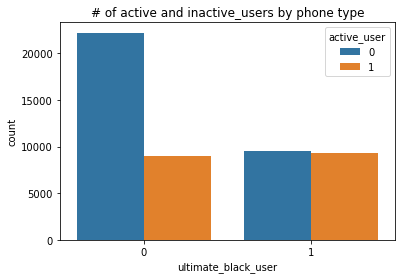

In [16]:
sns.countplot(data = ultimate, x='ultimate_black_user', hue='active_user')
plt.title('# of active and inactive_users by phone type')
plt.show()

#pd.crosstab https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html


The "Ultimate Black" users were much more likely to still be active after 6 months.

In [17]:
# ultimate['trips_in_first_30_days'].groupby(ultimate['active_user']).agg('mean')
ultimate.groupby(ultimate['active_user'])['trips_in_first_30_days'].mean()

active_user
0    1.659167
1    3.349590
Name: trips_in_first_30_days, dtype: float64

Those who took more trips in the first 30 days were definitely more likely to stay active users.

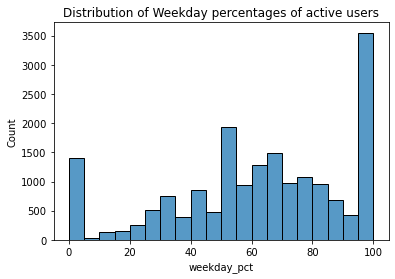

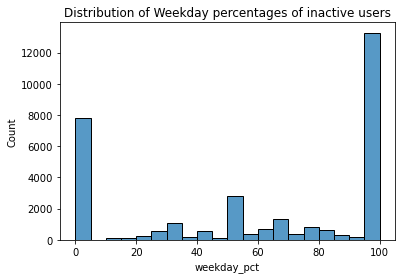

active_user
0    60.181597
1    62.214604
Name: weekday_pct, dtype: float64

In [18]:
active_user = ultimate[ultimate.active_user == 1]
inactive_user = ultimate[ultimate.active_user == 0]

sns.histplot(x = 'weekday_pct', data = active_user, bins=20)
plt.title('Distribution of Weekday percentages of active users')
plt.show()

sns.histplot(x = 'weekday_pct', data = inactive_user, bins=20)
plt.title('Distribution of Weekday percentages of inactive users')
plt.show()

ultimate['weekday_pct'].groupby(ultimate['active_user']).agg('mean')

#plot avg dist for active/inactive
#plot avg rating for active/inactive

The average weekday percentage use between inactive and active users is very similar, however, there tend to be a higher percentage of active users that ride on both the weekend and weekday.  Among inactive users, most people ride exclusively on either weekends or weekdays.

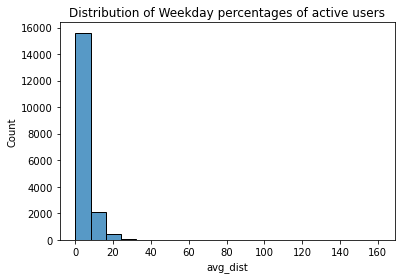

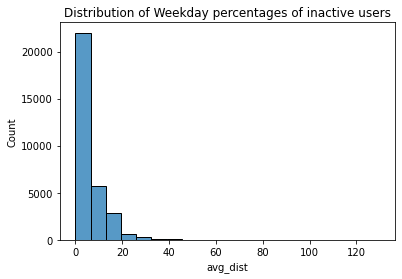

active_user
0    6.188478
1    5.118977
Name: avg_dist, dtype: float64

In [19]:
sns.histplot(x = 'avg_dist', data = active_user, bins=20)
plt.title('Distribution of Weekday percentages of active users')
plt.show()

sns.histplot(x = 'avg_dist', data = inactive_user, bins=20)
plt.title('Distribution of Weekday percentages of inactive users')
plt.show()

ultimate['avg_dist'].groupby(ultimate['active_user']).agg('mean')

The average distance of each trip is 1 mile less than for active users as opposed to inactive users.

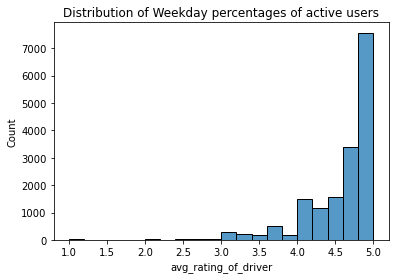

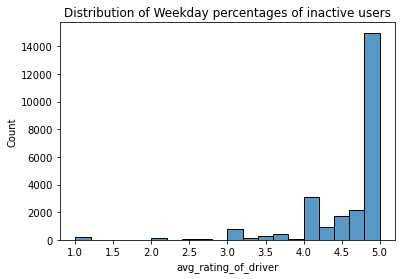

active_user
0    4.607018
1    4.593364
Name: avg_rating_of_driver, dtype: float64

In [20]:
sns.histplot(x = 'avg_rating_of_driver', data = active_user, bins=20)
plt.title('Distribution of Weekday percentages of active users')
plt.show()

sns.histplot(x = 'avg_rating_of_driver', data = inactive_user, bins=20)
plt.title('Distribution of Weekday percentages of inactive users')
plt.show()

ultimate['avg_rating_of_driver'].groupby(ultimate['active_user']).agg('mean')

The average driver rating of users appears pretty much the same between inactive and active users. This likely tells us that bad driver experiences are not a primary cause of retention failures.

# Pre-Processing

Now it's time for some pre-processing prior to modelling. First, I need to figure what to do with our NaN values. 

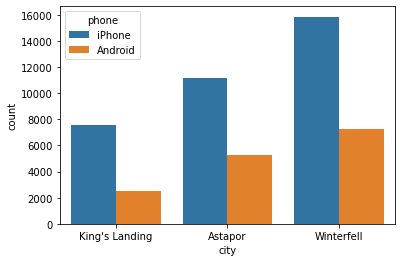

In [21]:
sns.countplot(data = ultimate, x='city', hue='phone')
plt.show()

No matter where a person lives, they are more likely to have the iPhone.  I think the best way to impute missing data is to fill the small % of NaNs we have with iPhone.

In [22]:
ultimate.phone.fillna('iPhone', inplace=True)

We also have some NaN in 2 our driver rating and user rating columns. I don't want to lose the information in those rows, and I think the best way to handle the NaN in this case would be to impute the means of the columns for each. 

In [23]:
ultimate.avg_rating_of_driver.fillna(ultimate.avg_rating_of_driver.mean(), inplace=True)
ultimate.avg_rating_by_driver.fillna(ultimate.avg_rating_by_driver.mean(), inplace=True)
ultimate.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  int32  
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
 12  active_user             50000 non-null  int64  
dtypes: float64(6), int32(1), int64(2), object(4)
memory usage: 4.8+ MB


In [24]:
dummies = pd.get_dummies(ultimate[['city', 'phone']], drop_first=True)



In [25]:
ultimate = ultimate.drop(columns = ['city', 'phone', 'signup_date', 'last_trip_date'] )
ultimate.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int32  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   active_user             50000 non-null  int64  
dtypes: float64(6), int32(1), int64(2)
memory usage: 3.2 MB


In [26]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   city_King's Landing  50000 non-null  uint8
 1   city_Winterfell      50000 non-null  uint8
 2   phone_iPhone         50000 non-null  uint8
dtypes: uint8(3)
memory usage: 146.6 KB


In [27]:
df = pd.concat([ultimate, dummies], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int32  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   active_user             50000 non-null  int64  
 9   city_King's Landing     50000 non-null  uint8  
 10  city_Winterfell         50000 non-null  uint8  
 11  phone_iPhone            50000 non-null  uint8  
dtypes: float64(6), int32(1), int64(2), uint8(3)
memory usage: 3.4 MB


Before splitting my data for modeling, I'm going to normalize the data.  This may help a couple of our machine learning algorythms work better.

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled.columns = df.columns

df_scaled.corr()

# Train,test, split
# apply my models
# score em

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,city_King's Landing,city_Winterfell,phone_iPhone
trips_in_first_30_days,1.000000,-0.011060,-0.001841,0.005720,0.112210,0.050388,-0.136329,-0.039097,0.214728,0.024650,0.037735,0.059309
avg_rating_of_driver,-0.011060,1.000000,-0.021653,-0.003290,-0.001916,0.012587,0.028508,0.101660,-0.010082,0.082156,-0.094304,-0.024206
avg_surge,-0.001841,-0.021653,1.000000,0.793582,-0.078791,-0.110071,-0.081491,0.010498,-0.003567,-0.009198,-0.027643,0.008977
surge_pct,0.005720,-0.003290,0.793582,1.000000,-0.106861,-0.144918,-0.104414,0.019964,0.010612,0.028221,-0.065603,0.010150
ultimate_black_user,0.112210,-0.001916,-0.078791,-0.106861,1.000000,0.035998,0.032310,0.009328,0.210259,0.039649,-0.051990,0.075836
weekday_pct,0.050388,0.012587,-0.110071,-0.144918,0.035998,1.000000,0.101652,0.020366,0.026413,0.031349,-0.015318,0.009241
avg_dist,-0.136329,0.028508,-0.081491,-0.104414,0.032310,0.101652,1.000000,0.079793,-0.090279,0.015877,0.030050,-0.020888
avg_rating_by_driver,-0.039097,0.101660,0.010498,0.019964,0.009328,0.020366,0.079793,1.000000,-0.025595,0.084480,-0.098727,-0.008765
active_user,0.214728,-0.010082,-0.003567,0.010612,0.210259,0.026413,-0.090279,-0.025595,1.000000,0.268272,-0.046985,0.231731
city_King's Landing,0.024650,0.082156,-0.009198,0.028221,0.039649,0.031349,0.015877,0.084480,0.268272,1.000000,-0.471555,0.059203


It looks like the most strongly correlated variables to whether a person is an active user or not are living in King's Landing, having an i-phone, being an 'ultimate black' user, and taking a higher than average # of trips in the first 30 days.

# Modeling

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score


In [30]:
X = df_scaled.drop(columns = 'active_user')
y = df_scaled['active_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## Random Forest

In [31]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('F1 Score:', round(f1_score(y_test, y_pred), 3))
print('Accuracy Score:', round(accuracy_score(y_test, y_pred), 3))
print('Precision Score:', round(precision_score(y_test, y_pred), 3))
print('Recall Score:', round(recall_score(y_test, y_pred), 3))

confusion_matrix(y_test, y_pred)

F1 Score: 0.671
Accuracy Score: 0.761
Precision Score: 0.68
Recall Score: 0.662


array([[5179, 1143],
       [1245, 2433]], dtype=int64)

## Decision Tree

In [32]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('F1 Score:', round(f1_score(y_test, y_pred), 3))
print('Accuracy Score:', round(accuracy_score(y_test, y_pred), 3))
print('Precision Score:', round(precision_score(y_test, y_pred), 3))
print('Recall Score:', round(recall_score(y_test, y_pred), 3))

confusion_matrix(y_test, y_pred)

F1 Score: 0.595
Accuracy Score: 0.706
Precision Score: 0.602
Recall Score: 0.589


array([[4889, 1433],
       [1511, 2167]], dtype=int64)

## Logistic Regression

In [33]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('F1 Score:', round(f1_score(y_test, y_pred), 3))
print('Accuracy Score:', round(accuracy_score(y_test, y_pred), 3))
print('Precision Score:', round(precision_score(y_test, y_pred), 3))
print('Recall Score:', round(recall_score(y_test, y_pred), 3))

confusion_matrix(y_test, y_pred)

F1 Score: 0.564
Accuracy Score: 0.718
Precision Score: 0.653
Recall Score: 0.497


array([[5350,  972],
       [1850, 1828]], dtype=int64)

## K-Neighbors Classifier

In [34]:
for i in range(3, 16, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print('Using', i, 'Neighbors')
    print('F1 Score:', round(f1_score(y_test, y_pred), 3))
    print('Accuracy Score:', round(accuracy_score(y_test, y_pred), 3))
    print('Precision Score:', round(precision_score(y_test, y_pred), 3))
    print('Recall Score:', round(recall_score(y_test, y_pred), 3))
    print(' ')

Using 3 Neighbors
F1 Score: 0.635
Accuracy Score: 0.74
Precision Score: 0.655
Recall Score: 0.616
 
Using 5 Neighbors
F1 Score: 0.647
Accuracy Score: 0.75
Precision Score: 0.675
Recall Score: 0.621
 
Using 7 Neighbors
F1 Score: 0.656
Accuracy Score: 0.758
Precision Score: 0.686
Recall Score: 0.629
 
Using 9 Neighbors
F1 Score: 0.655
Accuracy Score: 0.759
Precision Score: 0.69
Recall Score: 0.624
 
Using 11 Neighbors
F1 Score: 0.665
Accuracy Score: 0.765
Precision Score: 0.699
Recall Score: 0.634
 
Using 13 Neighbors
F1 Score: 0.666
Accuracy Score: 0.766
Precision Score: 0.7
Recall Score: 0.635
 
Using 15 Neighbors
F1 Score: 0.662
Accuracy Score: 0.764
Precision Score: 0.698
Recall Score: 0.629
 


## SVM

In [35]:
kernels = ['linear', 'poly', 'rbf']
for item in kernels:
    clf = SVC(kernel = item)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Kernel =', item)
    print('F1 Score:', round(f1_score(y_test, y_pred), 3))
    print('Accuracy Score:', round(accuracy_score(y_test, y_pred), 3))
    print('Precision Score:', round(precision_score(y_test, y_pred), 3))
    print('Recall Score:', round(recall_score(y_test, y_pred), 3))
    print(' ')

Kernel = linear
F1 Score: 0.507
Accuracy Score: 0.702
Precision Score: 0.648
Recall Score: 0.416
 
Kernel = poly
F1 Score: 0.637
Accuracy Score: 0.746
Precision Score: 0.67
Recall Score: 0.607
 
Kernel = rbf
F1 Score: 0.637
Accuracy Score: 0.739
Precision Score: 0.653
Recall Score: 0.623
 


## Modeling Conclusions

The most accurate models for predicting rider retention from this dataset appear to be the <b>Random Forest Classifier</b>, as well as the <b>KNeighbors Classifier</b>, using 13 neighbors for prediction.  With these models, we were able to predict whether a rider became an active user with <b>over 76% accuracy</b>.

# Final Conclusions and Recommendations

Through data exploration, it was determined that there were 4 specific variables that best predicted whether a rider signed up would still be an active user 6 months later. It appears that those users most likely to have stayed active often signed up via i-phone, resided in King's Landing, signed up as an ultimate black user, or took a higher than average # of trips in the initial 30 days. Using the data given and these variables, we were able to develop a model that can predict with over 76% accuracy.  Based on what we've seen, I would make the following recommendations.

1) I-phone users were much more likely to stay on board, which may indicate that Android users may have had some difficulty using the service.  I would recommend re-evaluating the user experience and application on the Android platform, to see if there are specific issues lowering retention of Android users.

2) King's Landing had a much higher retention rate, information which can provide a couple of different options. Knowing the higher likely retention, the company can hone in and focus just on the King's Landing area. However, if that is not the route the company is looking to take, it could boost marketing and increase incentives for those in the Winterfell and Astapor City areas, in an attempt to raise retention rates. 

3) Offer further incentives, rewards to brand new users to increase sign-up for the "Ultimate Black" program. Once customers are in that program, they are much more likely to stay active after 6 months.

4) Offer further incentives, rewards, and initial discounts to riders over their first 30 days. The more the riders use the service in the first month, the more likely they will be to continue to use it down the line.
